In [17]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam
from common.trainer import Trainer

%matplotlib inline

# 6.1 パラメータの効率的な更新，最適化
- optimizerを実装して，重みパラメータと勾配を渡して更新する
- optimizerを変えるだけで，異なる最適化アルゴリズムを使える

***
### Momentum
$$
\boldsymbol{v} \leftarrow \alpha \boldsymbol{v} - \eta \frac{\partial L}{\partial W}
\\ \\
W \leftarrow W + \boldsymbol{v}
$$

- $W$: 更新する重みパラメータ
- $\eta$: 学習率．インスタンス変数として
- $\boldsymbol{v}$: 速度にあたる変数．
- $\alpha$: 減速させる役割をもつ定数．(0.9などを使う)

In [2]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        # 初期化．速度の初期値はNone
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        # 初回更新時，vにparamsと同じ形状のデータをディクショナリとして持たせる
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        # paramsとvを更新する
        for key in params.keys():
            # 前回のvはmomentum分だけ減速，現在のparamsを元にした勾配で速度を更新
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            # 更新後の速度でparamsを更新
            params[key] += self.v[key]

***
### AdaGrad
$$
\boldsymbol{h} \leftarrow \boldsymbol{h} + \frac{\partial L}{\partial W} \otimes \frac{\partial L}{\partial W}
\\ \\
W \leftarrow W - \eta \frac{1}{\sqrt{\boldsymbol{h} + \epsilon}} \frac{\partial L}{\partial W}
$$

- $\otimes$ は要素ごとの積（アダマール積）を表す
- 学習率を減衰させる発想
- $\boldsymbol{h}$ は過去の勾配の2乗和を記憶していく
- 重みパラメータの更新の際には勾配を$\boldsymbol{h}$ で割ることで，徐々に更新の度合いを小さくする．平方根を取るのはスケールの調整．
- 無限に更新すると更新量が0になる．改良した手法としてRMSPropがある．

***
### RMSProp
$$
\boldsymbol{h} \leftarrow \beta \boldsymbol{h} + (1 - \beta) \frac{\partial L}{\partial W} \otimes \frac{\partial L}{\partial W}
\\ \\
W \leftarrow W - \eta \frac{1}{\sqrt{\boldsymbol{h} + \epsilon}} \frac{\partial L}{\partial W}
$$
- $\beta$ に0.9などの値を入れて，過去の勾配の影響を低下させ，新しい勾配の影響を大きくする


In [3]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

***
### Adam
$$
\begin{align}
\boldsymbol{m}_t &\leftarrow \beta_1 \boldsymbol{m}_{t-1} + (1 - \beta_1) \frac{\partial L}{\partial W}
\\ \\
\boldsymbol{v}_t &\leftarrow \beta_2 \boldsymbol{v}_{t-1} + (1 - \beta_2) \frac{\partial L}{\partial W} \otimes \frac{\partial L}{\partial W}
\\ \\
\boldsymbol{\hat{m}}_t &\leftarrow \frac{\boldsymbol{m}_t}{(1 - \beta_1^t)}
\\ \\
\boldsymbol{\hat{v}}_t &\leftarrow \frac{\boldsymbol{v}_t}{(1 - \beta_2^t)}
\\ \\
W_t &\leftarrow W_{t-1} - \eta \frac{\boldsymbol{\hat{m}}_t}{\sqrt{\boldsymbol{\hat{v}}_t} + \epsilon}
\end{align}
$$

- [原著論文](https://paperswithcode.com/paper/adam-a-method-for-stochastic-optimization)
- MomentumとAdaGradの組み合わせ
- $\boldsymbol{m}$ はモーメント．勾配の移動平均．速度を保持．
- $\boldsymbol{v}$ は更新量．勾配の大きさの移動平均．過去のイテレーションで勾配が大きかったパラメータの更新量は小さく，勾配が小さかったパラメータの更新量は大きく調整．
- $\boldsymbol{m}, \ \boldsymbol{v}$ を $(1 - \beta^t)$ で割ることで，イテレーションの初期では大きく，イテレーションが進むほど小さくなるよう調整する．$\boldsymbol{m}_0, \ \boldsymbol{v}_0$ は0から始まるため，$t = 1$ のときなど，$\boldsymbol{m}, \ \boldsymbol{v}$ は非常に小さい値になってしまう．

***
### 最適化アルゴリズムの比較

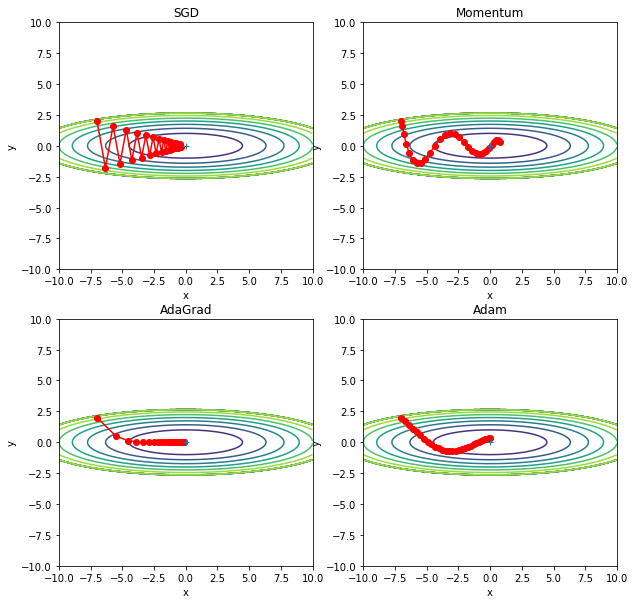

In [4]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *

%matplotlib inline


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1
plt.figure(figsize=(10, 10))

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

# 6.2 重みの初期値
- 重みをなるべく小さくすることで，過学習が起きにくくなる（Weight decay = 荷重減衰）
- 初期値を均一な値にしてはいけない．全ての重みが均一に更新される

Affine変換 $\boldsymbol{x} W + \boldsymbol{b}= \boldsymbol{a}$ において，重みが均一な場合，次の層への出力，backpropの勾配が均一になる

中間層の全ノードへの入力が同じであるということは，複数のノードが存在する意味がなくなるということ

***
### 隠れ層のアクティベーション分布
##### 重みの初期値にガウス分布を用いて，その標準偏差を変えたときに隠れ層のアクティベーション関数の出力の分布がどう変化するかを観察
- 5層，各層は100個のニューロンを持つニューラルネットワークで実験

##### 活性化関数: Sigmoid
- 出力が0や1に偏りすぎると，勾配の値が小さくなり勾配消失に至る
- 出力が0.5付近であっても，同じ出力ばかりだとニューロンの多様性が失われ，表現力が制限される
- 前層ノード数を $n$ としたとき，$\sqrt{\frac{1}{n}}$ の標準偏差を持つ分布を使う:「Xavierの初期値」
- Xavierの初期値は活性化関数が線形であることを前提としたものだが，Sigmoidは中央付近が線形とみなせるため効果がある．

##### 活性化関数: ReLU
- ReLUに適したHeの初期値が使われる
- 前層ノード数を $n$ としたとき，$\sqrt{\frac{2}{n}}$ の標準偏差を持つ分布を使う
- 直観的な解釈: ReLUでは入力が負の場合は全て出力0になる＝多様性が低いため初期値のばらつきを大きくとる

***
#### 実験: アクティベーション関数の種類，初期値の正規分布の標準偏差を変えて出力の分布を確認する

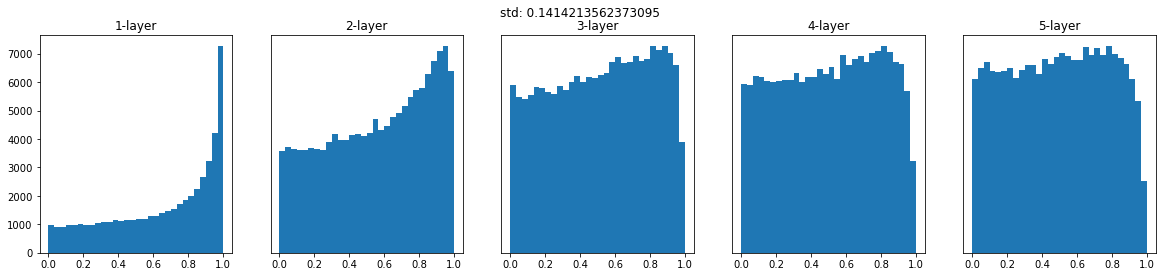

In [31]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
#     std = 1
#     std = 0.01
#     std = np.sqrt(1.0 / node_num) # Sigmoid 最適
    std = np.sqrt(2.0 / node_num) # ReLU 最適

    w = np.random.randn(node_num, node_num) * std

    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
#     z = sigmoid(a)
#     z = ReLU(a)
    z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
plt.figure(figsize=(20, 4))
plt.suptitle('std: ' + str(std))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

***
# 6.3 Batch Normalization
$$
\begin{align}
\mu_{j} &\leftarrow \frac{1}{n} \Sigma_{i=1}^{n} x_{ij}
\\ \\
\sigma_{j}^2 &\leftarrow \frac{1}{n} \Sigma_{i=1}^{n} (x_{ij} - \mu_{j})^2
\\ \\
\hat{x}_{ij} &\leftarrow \frac{x_{ij} - \mu_{j}}{\sqrt{\sigma_{j}^2 + \epsilon}}
\\ \\
y_{ij} &\leftarrow \gamma_j \hat{x}_{ij} + \beta_j
\end{align}
$$
- アクティベーション関数の出力分布を調整する手法
- ミニバッチとして，サンプル数 $n$，次元 $m$ の以下の入力を考える（ノード数 $m$ である層からの出力）
$$
B = 
\begin{pmatrix}
x_{11} & x_{12} & \cdots & x_{1m} \\
x_{21} & x_{22} & \cdots & x_{2m} \\
\vdots & \vdots & & \vdots \\
x_{n1} & x_{n2} & \cdots & x_{nm} \\
\end{pmatrix}
$$


- 入力データの各成分のミニバッチ全体の平均 $\mu_j$，分散 $\sigma_j$ を求める
- $\mu_j, \ \sigma_j$ を使って，データを標準化し，平均0，分散1にする（$\epsilon$ は0除算を防ぐため）
- 最後に固有のスケールとシフトで変換する．$\gamma, \ \beta$ はパラメータ．平均 $\beta$，分散 $\gamma$ になる？

***

#### 偏微分導出
- $\mu_{j} \leftarrow \frac{1}{n} \Sigma_{i=1}^{n} x_{ij}$ について
$$
\mu_{j} = \frac{1}{n} (x_{1j} + x_{2j} + \cdots + x_{nj})
$$
より
$$
\frac{\partial \mu_{j}}{\partial x_{ij}} = \frac{1}{n}
$$
<br><br>


- $\sigma_{j}^2 \leftarrow \frac{1}{n} \Sigma_{i=1}^{n} (x_{ij} - \mu_{j})^2$ について
$$
\begin{align}
    \frac{\partial \sigma_{j}^2}{\partial x_{ij}} 
        &= \frac{1}{n} \left\{
            \frac{\partial (x_{1j} - \mu_j)^2}{\partial x_{ij}} + \frac{\partial (x_{2j} - \mu_j)^2}{\partial x_{ij}} + \cdots + \frac{\partial (x_{nj} - \mu_j)^2}{\partial x_{ij}}
        \right\}
        \\
        &= \frac{1}{n} \Sigma_{\lambda=1}^{n} \frac{\partial (x_{\lambda j} - \mu_j)^2}{\partial x_{ij}}
        \\
        &= \frac{2}{n} \Sigma_{\lambda=1}^{n} (x_{\lambda j} - \mu_{j}) \frac{\partial (x_{\lambda j} - \mu_j)}{\partial x_{ij}}
        \\
        &= \frac{2}{n} \Sigma_{\lambda=1}^{n} (x_{\lambda j} - \mu_{j}) \left( \frac{\partial x_{\lambda j}}{\partial x_{ij}} - \frac{\partial \mu_j}{\partial x_{ij}} \right)
        \\
        &= \frac{2}{n} \Sigma_{\lambda=1}^{n} (x_{\lambda j} - \mu_{j}) \left( \delta_{i \lambda} - \frac{1}{n} \right)
        \\
        &= \frac{2}{n} \Sigma_{\lambda=1}^{n} \delta_{i \lambda} (x_{\lambda j} - \mu_{j}) - \frac{2}{n^2} \Sigma_{\lambda=1}^{n} (x_{\lambda j} - \mu_{j})
        \\
        &= \frac{2}{n} (x_{ij} - \mu_{j}) - \frac{2}{n} \left( \frac{1}{n} \Sigma_{\lambda=1}^{n} x_{\lambda j} - \frac{1}{n} \Sigma_{\lambda=1}^{n} \mu_j \right)
        \\
        &= \frac{2}{n} (x_{ij} - \mu_{j}) - \frac{2}{n} (\mu_j - \mu_j)
        \\
        &= \frac{2}{n} (x_{ij} - \mu_{j})
\end{align}
$$
<br><br>



- $\hat{x}_{ij} \leftarrow \frac{x_{ij} - \mu_{j}}{\sqrt{\sigma_{j}^2 + \epsilon}}$ について

$s_j = \sqrt{\sigma_j^2 + \epsilon}$ とおけば 

$$
\begin{align}
    \frac{\partial s_j}{\partial x_{ij}}
        &= \frac{\partial s_j}{\partial \sigma_j^2} \frac{\partial \sigma_j^2}{\partial x_{ij}}
        \\
        &= \frac{1}{2 \sqrt{\sigma_j^2 + \epsilon}} \frac{2}{n} (x_{ij} - \mu_{j})
        \\
        &= \frac{x_{ij} - \mu_{j}}{n s_j}
    \\
    \\
    \frac{\partial \hat{x}_{kj}}{\partial x_{ij}}
        &= \frac{1}{s_j^2} \left\{
            s_j \frac{\partial (x_{kj} - \mu_{j})}{\partial x_{ij}} - \frac{\partial s_j}{\partial x_{ij}} (x_{kj} - \mu_{j})
        \right\}
        \\
        &= \frac{1}{s_j^2} \left\{
            s_j \left( \delta_{ik} - \frac{1}{n} \right) - \frac{x_{ij} - \mu_{j}}{n s_j} (x_{kj} - \mu_{j})
        \right\}
        \\
        &= \frac{1}{s_j} \left\{
            \delta_{ik} - \frac{1}{n} - \frac{(x_{ij} - \mu_{j})(x_{kj} - \mu_{j})}{n s_j^2}
        \right\}
        \\
        &= \frac{1}{s_j} \left(
            \delta_{ik} - \frac{1}{n} - \frac{\hat{x}_{ij} \hat{x}_{kj}}{n}
        \right)
\end{align}
$$
<br><br>


- $y_{ij} \leftarrow \gamma_j \hat{x}_{ij} + \beta_j$ について
$$
\begin{align}
    \frac{\partial y_{kj}}{\partial x_{ij}}
        &= \frac{\partial y_{kj}}{\partial \hat{x}_{kj}} \frac{\partial \hat{x}_{kj}}{\partial x_{ij}}
        \\
        &= \frac{\gamma_j}{s_j} \left(
            \delta_{ik} - \frac{1}{n} - \frac{\hat{x}_{ij} \hat{x}_{kj}}{n}
        \right)
    \\
    \\
    \frac{\partial y_{kj}}{\partial \beta_j} &= 1
    \\
    \\
    \frac{\partial y_{kj}}{\partial \gamma_j} &= \hat{x}_{kj}
\end{align}
$$
<br><br>


- 損失関数 $L$ の偏微分

第 $j$ ノードに対する損失は $y_{1j}, y_{2j}, \cdots, y_{nj}$ の関数

出力 $y_{ij}$ は $x_{1j}, x_{2j}, \cdots, x_{nj}$ の関数

$$
\begin{align}
    \frac{\partial L}{\partial x_{ij}}
        &= \Sigma_{\lambda=1}^{n} \frac{\partial L}{\partial y_{\lambda j}} \frac{\partial y_{\lambda j}}{\partial x_{ij}}
        \\
        &= \Sigma_{\lambda=1}^{n} \frac{\partial L}{\partial y_{\lambda j}} \frac{\gamma_j}{s_j} \left(
            \delta_{i \lambda} - \frac{1}{n} - \frac{\hat{x}_{ij} \hat{x}_{\lambda j}}{n}
        \right)
        \\
        &= \frac{\gamma_j}{s_j} \left\{
            \frac{\partial L}{\partial y_{ij}} - \frac{1}{n} \Sigma_{\lambda=1}^{n} (1 + \hat{x}_{ij} \hat{x}_{\lambda j}) \frac{\partial L}{\partial y_{\lambda j}}
        \right\}
\end{align}
$$

正規化パラメータ$\beta_j, \ \gamma_j$ について，

$$
\begin{align}
    \frac{\partial L}{\partial \beta_j}
        &= \Sigma_{\lambda=1}^{n} \frac{\partial L}{\partial y_{\lambda j}} \frac{\partial y_{\lambda j}}{\partial \beta_j}
        \\
        &= \Sigma_{\lambda=1}^{n} \frac{\partial L}{\partial y_{\lambda j}}
    \\
    \\
    \frac{\partial L}{\partial \gamma_j}
        &= \Sigma_{\lambda=1}^{n} \frac{\partial L}{\partial y_{\lambda j}} \frac{\partial y_{\lambda j}}{\partial \gamma_j}
        \\
        &= \Sigma_{\lambda=1}^{n} \hat{x}_{\lambda j} \frac{\partial L}{\partial y_{\lambda j}}
\end{align}
$$

よって

$$
\begin{align}
    \frac{\partial L}{\partial x_{ij}}
    &= \frac{\gamma_j}{s_j} \left\{
            \frac{\partial L}{\partial y_{ij}} - \frac{1}{n} \Sigma_{\lambda=1}^{n} (1 + \hat{x}_{ij} \hat{x}_{\lambda j}) \frac{\partial L}{\partial y_{\lambda j}}
        \right\}
    \\
    &= \frac{\gamma_j}{s_j} \left\{
            \frac{\partial L}{\partial y_{ij}} - \frac{1}{n} \left( \frac{\partial L}{\partial \beta_j} + \hat{x}_{ij} \frac{\partial L}{\partial \gamma_{j}} \right) \right\}
\end{align}
$$

***
#### Batch Normを使った実験

============== 1/16 ==============
epoch:0 | 0.105 - 0.116


/home/jovyan/work/deep-learning-from-scratch/ch06/../common/functions.py:32: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策


epoch:1 | 0.097 - 0.136
epoch:2 | 0.097 - 0.135
epoch:3 | 0.097 - 0.139
epoch:4 | 0.097 - 0.151
epoch:5 | 0.097 - 0.168
epoch:6 | 0.097 - 0.188
epoch:7 | 0.097 - 0.207
epoch:8 | 0.097 - 0.222
epoch:9 | 0.097 - 0.247
epoch:10 | 0.097 - 0.267
epoch:11 | 0.097 - 0.28
epoch:12 | 0.097 - 0.298
epoch:13 | 0.097 - 0.311
epoch:14 | 0.097 - 0.322
epoch:15 | 0.097 - 0.338
epoch:16 | 0.097 - 0.355
epoch:17 | 0.097 - 0.371
epoch:18 | 0.097 - 0.385


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.396
============== 2/16 ==============
epoch:0 | 0.117 - 0.106
epoch:1 | 0.097 - 0.139
epoch:2 | 0.097 - 0.153
epoch:3 | 0.097 - 0.157
epoch:4 | 0.097 - 0.166
epoch:5 | 0.097 - 0.19
epoch:6 | 0.097 - 0.215
epoch:7 | 0.097 - 0.239
epoch:8 | 0.097 - 0.264
epoch:9 | 0.097 - 0.292
epoch:10 | 0.097 - 0.305
epoch:11 | 0.097 - 0.325
epoch:12 | 0.097 - 0.357
epoch:13 | 0.097 - 0.36
epoch:14 | 0.097 - 0.391
epoch:15 | 0.097 - 0.405
epoch:16 | 0.097 - 0.417
epoch:17 | 0.097 - 0.441
epoch:18 | 0.097 - 0.47


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.487
============== 3/16 ==============
epoch:0 | 0.142 - 0.065
epoch:1 | 0.307 - 0.106
epoch:2 | 0.479 - 0.157
epoch:3 | 0.585 - 0.202
epoch:4 | 0.645 - 0.24
epoch:5 | 0.686 - 0.28
epoch:6 | 0.75 - 0.317
epoch:7 | 0.788 - 0.348
epoch:8 | 0.787 - 0.378
epoch:9 | 0.852 - 0.411
epoch:10 | 0.881 - 0.432
epoch:11 | 0.893 - 0.461
epoch:12 | 0.918 - 0.479
epoch:13 | 0.926 - 0.506
epoch:14 | 0.938 - 0.543
epoch:15 | 0.943 - 0.557
epoch:16 | 0.952 - 0.577
epoch:17 | 0.958 - 0.585
epoch:18 | 0.961 - 0.609


No handles with labels found to put in legend.


epoch:19 | 0.966 - 0.619
============== 4/16 ==============
epoch:0 | 0.128 - 0.094
epoch:1 | 0.293 - 0.136
epoch:2 | 0.419 - 0.193
epoch:3 | 0.486 - 0.273
epoch:4 | 0.555 - 0.362
epoch:5 | 0.599 - 0.445
epoch:6 | 0.618 - 0.501
epoch:7 | 0.666 - 0.54
epoch:8 | 0.704 - 0.568
epoch:9 | 0.714 - 0.616
epoch:10 | 0.729 - 0.642
epoch:11 | 0.747 - 0.668
epoch:12 | 0.759 - 0.687
epoch:13 | 0.769 - 0.704
epoch:14 | 0.794 - 0.711
epoch:15 | 0.797 - 0.729
epoch:16 | 0.814 - 0.738
epoch:17 | 0.828 - 0.754
epoch:18 | 0.834 - 0.767


No handles with labels found to put in legend.


epoch:19 | 0.85 - 0.773
============== 5/16 ==============
epoch:0 | 0.116 - 0.111
epoch:1 | 0.116 - 0.148
epoch:2 | 0.116 - 0.249
epoch:3 | 0.116 - 0.376
epoch:4 | 0.117 - 0.502
epoch:5 | 0.12 - 0.578
epoch:6 | 0.123 - 0.644
epoch:7 | 0.136 - 0.676
epoch:8 | 0.148 - 0.716
epoch:9 | 0.18 - 0.737
epoch:10 | 0.204 - 0.762
epoch:11 | 0.22 - 0.784
epoch:12 | 0.243 - 0.798
epoch:13 | 0.267 - 0.816
epoch:14 | 0.297 - 0.825
epoch:15 | 0.319 - 0.834
epoch:16 | 0.351 - 0.852
epoch:17 | 0.358 - 0.863
epoch:18 | 0.355 - 0.878


No handles with labels found to put in legend.


epoch:19 | 0.368 - 0.88
============== 6/16 ==============
epoch:0 | 0.137 - 0.112
epoch:1 | 0.117 - 0.223
epoch:2 | 0.121 - 0.44
epoch:3 | 0.14 - 0.584
epoch:4 | 0.104 - 0.642
epoch:5 | 0.101 - 0.697
epoch:6 | 0.115 - 0.737
epoch:7 | 0.115 - 0.761
epoch:8 | 0.116 - 0.792
epoch:9 | 0.101 - 0.812
epoch:10 | 0.1 - 0.834
epoch:11 | 0.112 - 0.862
epoch:12 | 0.116 - 0.877
epoch:13 | 0.116 - 0.883
epoch:14 | 0.116 - 0.904
epoch:15 | 0.116 - 0.907
epoch:16 | 0.116 - 0.922
epoch:17 | 0.116 - 0.927
epoch:18 | 0.116 - 0.933


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.942
============== 7/16 ==============
epoch:0 | 0.093 - 0.143
epoch:1 | 0.117 - 0.354
epoch:2 | 0.116 - 0.665
epoch:3 | 0.116 - 0.744
epoch:4 | 0.116 - 0.785
epoch:5 | 0.116 - 0.819
epoch:6 | 0.116 - 0.843
epoch:7 | 0.116 - 0.863
epoch:8 | 0.117 - 0.89
epoch:9 | 0.117 - 0.914
epoch:10 | 0.116 - 0.93
epoch:11 | 0.117 - 0.942
epoch:12 | 0.117 - 0.948
epoch:13 | 0.117 - 0.957
epoch:14 | 0.117 - 0.966
epoch:15 | 0.117 - 0.972
epoch:16 | 0.117 - 0.975
epoch:17 | 0.117 - 0.979
epoch:18 | 0.117 - 0.987


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.99
============== 8/16 ==============
epoch:0 | 0.117 - 0.117
epoch:1 | 0.117 - 0.316
epoch:2 | 0.117 - 0.533
epoch:3 | 0.117 - 0.703
epoch:4 | 0.117 - 0.781
epoch:5 | 0.117 - 0.833
epoch:6 | 0.117 - 0.869
epoch:7 | 0.116 - 0.891
epoch:8 | 0.116 - 0.933
epoch:9 | 0.116 - 0.957
epoch:10 | 0.116 - 0.969
epoch:11 | 0.117 - 0.977
epoch:12 | 0.116 - 0.989
epoch:13 | 0.116 - 0.992
epoch:14 | 0.116 - 0.993
epoch:15 | 0.116 - 0.994
epoch:16 | 0.116 - 0.996
epoch:17 | 0.116 - 0.998
epoch:18 | 0.116 - 0.998


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.999
============== 9/16 ==============
epoch:0 | 0.099 - 0.116
epoch:1 | 0.099 - 0.546
epoch:2 | 0.099 - 0.777
epoch:3 | 0.099 - 0.839
epoch:4 | 0.099 - 0.906
epoch:5 | 0.099 - 0.935
epoch:6 | 0.116 - 0.959
epoch:7 | 0.116 - 0.97
epoch:8 | 0.116 - 0.986
epoch:9 | 0.116 - 0.992
epoch:10 | 0.116 - 0.997
epoch:11 | 0.116 - 0.994
epoch:12 | 0.116 - 0.999
epoch:13 | 0.116 - 1.0
epoch:14 | 0.116 - 1.0
epoch:15 | 0.116 - 1.0
epoch:16 | 0.116 - 1.0
epoch:17 | 0.116 - 1.0
epoch:18 | 0.116 - 1.0


No handles with labels found to put in legend.


epoch:19 | 0.116 - 1.0
============== 10/16 ==============
epoch:0 | 0.1 - 0.108
epoch:1 | 0.105 - 0.542
epoch:2 | 0.117 - 0.768
epoch:3 | 0.117 - 0.874
epoch:4 | 0.117 - 0.9
epoch:5 | 0.117 - 0.879
epoch:6 | 0.117 - 0.961
epoch:7 | 0.117 - 0.973
epoch:8 | 0.117 - 0.978
epoch:9 | 0.117 - 0.984
epoch:10 | 0.117 - 0.983
epoch:11 | 0.116 - 0.991
epoch:12 | 0.117 - 0.992
epoch:13 | 0.117 - 0.984
epoch:14 | 0.116 - 0.995
epoch:15 | 0.116 - 0.995
epoch:16 | 0.117 - 0.994
epoch:17 | 0.116 - 0.989
epoch:18 | 0.116 - 0.997


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.998
============== 11/16 ==============
epoch:0 | 0.097 - 0.129
epoch:1 | 0.117 - 0.532
epoch:2 | 0.117 - 0.666
epoch:3 | 0.117 - 0.753
epoch:4 | 0.117 - 0.861
epoch:5 | 0.117 - 0.928
epoch:6 | 0.117 - 0.94
epoch:7 | 0.117 - 0.944
epoch:8 | 0.116 - 0.968
epoch:9 | 0.117 - 0.978
epoch:10 | 0.117 - 0.957
epoch:11 | 0.117 - 0.922
epoch:12 | 0.117 - 0.976
epoch:13 | 0.117 - 0.977
epoch:14 | 0.117 - 0.99
epoch:15 | 0.117 - 0.987
epoch:16 | 0.117 - 0.992
epoch:17 | 0.117 - 0.947
epoch:18 | 0.117 - 0.995


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.992
============== 12/16 ==============
epoch:0 | 0.117 - 0.244
epoch:1 | 0.116 - 0.541
epoch:2 | 0.116 - 0.457
epoch:3 | 0.117 - 0.652
epoch:4 | 0.116 - 0.763
epoch:5 | 0.117 - 0.717
epoch:6 | 0.117 - 0.78
epoch:7 | 0.117 - 0.775
epoch:8 | 0.117 - 0.818
epoch:9 | 0.117 - 0.788
epoch:10 | 0.117 - 0.808
epoch:11 | 0.117 - 0.633
epoch:12 | 0.117 - 0.774
epoch:13 | 0.117 - 0.827
epoch:14 | 0.117 - 0.822
epoch:15 | 0.117 - 0.804
epoch:16 | 0.117 - 0.798
epoch:17 | 0.117 - 0.741
epoch:18 | 0.117 - 0.8


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.803
============== 13/16 ==============
epoch:0 | 0.094 - 0.142
epoch:1 | 0.117 - 0.459
epoch:2 | 0.116 - 0.548
epoch:3 | 0.116 - 0.62
epoch:4 | 0.116 - 0.642
epoch:5 | 0.116 - 0.619
epoch:6 | 0.116 - 0.684
epoch:7 | 0.116 - 0.641
epoch:8 | 0.116 - 0.677
epoch:9 | 0.117 - 0.653
epoch:10 | 0.117 - 0.694
epoch:11 | 0.117 - 0.698
epoch:12 | 0.117 - 0.69
epoch:13 | 0.117 - 0.701
epoch:14 | 0.117 - 0.701
epoch:15 | 0.117 - 0.698
epoch:16 | 0.117 - 0.7
epoch:17 | 0.117 - 0.699
epoch:18 | 0.117 - 0.702


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.699
============== 14/16 ==============
epoch:0 | 0.117 - 0.1
epoch:1 | 0.116 - 0.424
epoch:2 | 0.117 - 0.41
epoch:3 | 0.116 - 0.492
epoch:4 | 0.116 - 0.444
epoch:5 | 0.116 - 0.509
epoch:6 | 0.116 - 0.602
epoch:7 | 0.117 - 0.606
epoch:8 | 0.117 - 0.606
epoch:9 | 0.117 - 0.608
epoch:10 | 0.117 - 0.612
epoch:11 | 0.117 - 0.61
epoch:12 | 0.117 - 0.618
epoch:13 | 0.117 - 0.618
epoch:14 | 0.117 - 0.613
epoch:15 | 0.117 - 0.619
epoch:16 | 0.117 - 0.618
epoch:17 | 0.117 - 0.621
epoch:18 | 0.117 - 0.63


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.704
============== 15/16 ==============
epoch:0 | 0.116 - 0.177
epoch:1 | 0.117 - 0.406
epoch:2 | 0.117 - 0.42
epoch:3 | 0.117 - 0.48
epoch:4 | 0.117 - 0.489
epoch:5 | 0.117 - 0.507
epoch:6 | 0.117 - 0.34
epoch:7 | 0.117 - 0.506
epoch:8 | 0.117 - 0.514
epoch:9 | 0.117 - 0.517
epoch:10 | 0.117 - 0.519
epoch:11 | 0.117 - 0.396
epoch:12 | 0.117 - 0.52
epoch:13 | 0.117 - 0.515
epoch:14 | 0.117 - 0.523
epoch:15 | 0.117 - 0.524
epoch:16 | 0.117 - 0.522
epoch:17 | 0.117 - 0.522
epoch:18 | 0.117 - 0.524


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.524
============== 16/16 ==============
epoch:0 | 0.099 - 0.099
epoch:1 | 0.099 - 0.302
epoch:2 | 0.117 - 0.288
epoch:3 | 0.117 - 0.399
epoch:4 | 0.117 - 0.483
epoch:5 | 0.117 - 0.477
epoch:6 | 0.117 - 0.511
epoch:7 | 0.117 - 0.499
epoch:8 | 0.117 - 0.508
epoch:9 | 0.117 - 0.493
epoch:10 | 0.117 - 0.499
epoch:11 | 0.117 - 0.504
epoch:12 | 0.117 - 0.509
epoch:13 | 0.117 - 0.502
epoch:14 | 0.117 - 0.518
epoch:15 | 0.117 - 0.501
epoch:16 | 0.117 - 0.543
epoch:17 | 0.117 - 0.612
epoch:18 | 0.117 - 0.619
epoch:19 | 0.117 - 0.574


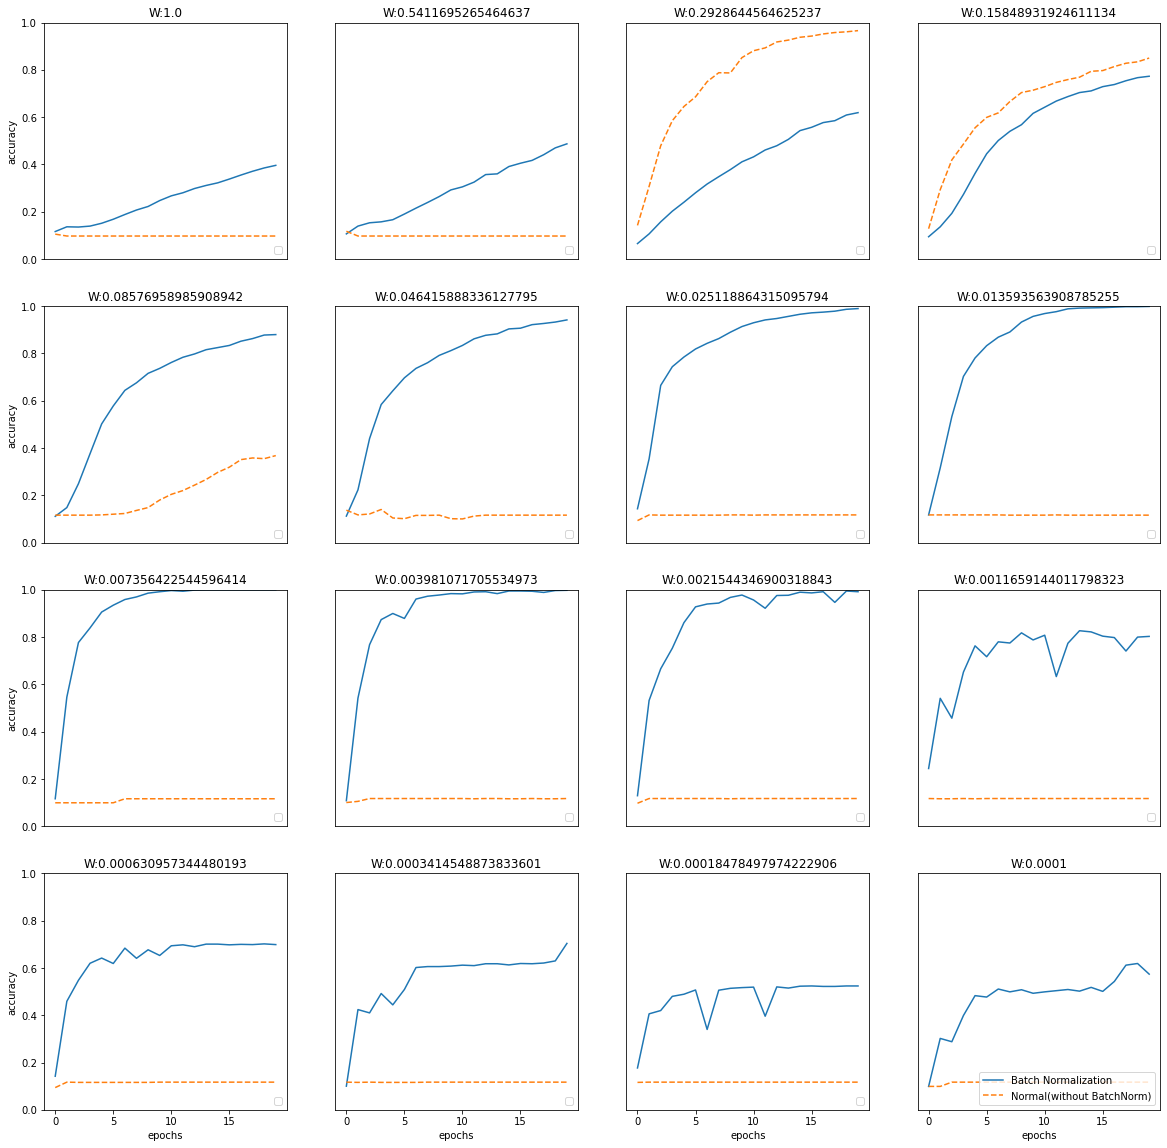

In [4]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 学習データを削減
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 3.グラフの描画==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

plt.figure(figsize=(20, 20))
for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

# 6.4 正則化

### 過学習の状態を確認
- train setに対する精度が非常に高い一方，test setに対する精度が低い
- train setにだけ，過剰に最適化されている状態＝汎化性能が低い


### Weight decay
- 作戦: 「重みパラメータが大きい値を取りにくくする」
- 損失関数に重みパラメータのL2ノルムを足す（L1ノルム，Maxノルムなど様々ある）

損失関数を $L(X)$（2乗和誤差や交差エントロピー誤差），パラメータを $W$，Weight decayの強さを制御するハイパーパラメータを $C$ とすれば，以下のように損失を計算する
$$
Loss = L(X) + \frac{1}{2} C W^2
$$

epoch:0, train acc:0.07666666666666666, test acc:0.0859
epoch:1, train acc:0.07666666666666666, test acc:0.0913
epoch:2, train acc:0.09666666666666666, test acc:0.1029
epoch:3, train acc:0.15333333333333332, test acc:0.1318
epoch:4, train acc:0.16666666666666666, test acc:0.1522
epoch:5, train acc:0.19666666666666666, test acc:0.168
epoch:6, train acc:0.22666666666666666, test acc:0.1781
epoch:7, train acc:0.23333333333333334, test acc:0.1889
epoch:8, train acc:0.26666666666666666, test acc:0.2087
epoch:9, train acc:0.33, test acc:0.2364
epoch:10, train acc:0.33, test acc:0.249
epoch:11, train acc:0.34, test acc:0.2493
epoch:12, train acc:0.35333333333333333, test acc:0.2636
epoch:13, train acc:0.37333333333333335, test acc:0.2715
epoch:14, train acc:0.38, test acc:0.2954
epoch:15, train acc:0.41333333333333333, test acc:0.3174
epoch:16, train acc:0.45666666666666667, test acc:0.347
epoch:17, train acc:0.4866666666666667, test acc:0.3738
epoch:18, train acc:0.52, test acc:0.3929
epoch:

epoch:162, train acc:0.8966666666666666, test acc:0.7406
epoch:163, train acc:0.9, test acc:0.7437
epoch:164, train acc:0.9033333333333333, test acc:0.7418
epoch:165, train acc:0.91, test acc:0.7506
epoch:166, train acc:0.9033333333333333, test acc:0.7387
epoch:167, train acc:0.8966666666666666, test acc:0.7346
epoch:168, train acc:0.91, test acc:0.7429
epoch:169, train acc:0.8933333333333333, test acc:0.7433
epoch:170, train acc:0.9033333333333333, test acc:0.7509
epoch:171, train acc:0.9066666666666666, test acc:0.7503
epoch:172, train acc:0.9066666666666666, test acc:0.7483
epoch:173, train acc:0.9066666666666666, test acc:0.7496
epoch:174, train acc:0.91, test acc:0.7456
epoch:175, train acc:0.9133333333333333, test acc:0.7442
epoch:176, train acc:0.9033333333333333, test acc:0.743
epoch:177, train acc:0.9066666666666666, test acc:0.7467
epoch:178, train acc:0.9133333333333333, test acc:0.7474
epoch:179, train acc:0.9066666666666666, test acc:0.7503
epoch:180, train acc:0.906666666

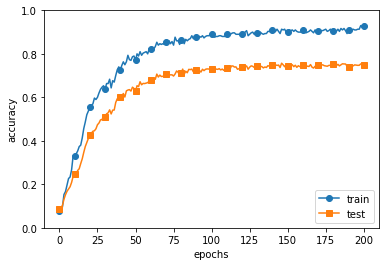

In [8]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（荷重減衰）の設定 =======================
# weight_decay_lambda = 0 # weight decayを使用しない場合
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### Dropout
- 作戦: 「ニューロンを減らして，ネットワークが複雑になりすぎないようにする」
- 隠れ層のニューロンをランダムに消去して学習
- テスト時は全てのニューロンを使うが，学習時に消去した割合を乗算して出力する

わかりやすさ重視の実装例

In [15]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flg=True):
        # 学習ではself.maskに消去するニューロンを保持する
        # テストではdropout_ratioを乗算
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio # *(tuple)でアンパック
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        # maskを使って消去したニューロンは逆伝播を止める
        return dout * self.mask

train loss:2.2765849540717307
=== epoch:1, train acc:0.09333333333333334, test acc:0.0995 ===
train loss:2.295646630623628
train loss:2.276531788667481
train loss:2.288309372121569
=== epoch:2, train acc:0.09333333333333334, test acc:0.1001 ===
train loss:2.29262304278862
train loss:2.2824113218612365
train loss:2.2951249332985832
=== epoch:3, train acc:0.09333333333333334, test acc:0.1013 ===
train loss:2.3072974369767287
train loss:2.2919940869791304
train loss:2.2795982685153113
=== epoch:4, train acc:0.09333333333333334, test acc:0.1019 ===
train loss:2.295959704217487
train loss:2.2933097356901433
train loss:2.276261709100366
=== epoch:5, train acc:0.1, test acc:0.1043 ===
train loss:2.2849523719482545
train loss:2.2734593576629787
train loss:2.2783171720294053
=== epoch:6, train acc:0.10333333333333333, test acc:0.1055 ===
train loss:2.292559034765398
train loss:2.2983963947888473
train loss:2.296958896893899
=== epoch:7, train acc:0.10333333333333333, test acc:0.107 ===
train lo

=== epoch:57, train acc:0.2966666666666667, test acc:0.2834 ===
train loss:2.1964105749760647
train loss:2.190082881459271
train loss:2.18205663880677
=== epoch:58, train acc:0.29, test acc:0.2809 ===
train loss:2.1622179316314947
train loss:2.2247312943400677
train loss:2.2206486724932404
=== epoch:59, train acc:0.2966666666666667, test acc:0.2841 ===
train loss:2.2136372551331123
train loss:2.1992438684534235
train loss:2.1816996897503986
=== epoch:60, train acc:0.2966666666666667, test acc:0.2858 ===
train loss:2.208158019669922
train loss:2.1393459722387873
train loss:2.159858275964384
=== epoch:61, train acc:0.29333333333333333, test acc:0.2856 ===
train loss:2.1683505034564217
train loss:2.2250317606189873
train loss:2.2288027498200855
=== epoch:62, train acc:0.30666666666666664, test acc:0.2869 ===
train loss:2.2121999119705773
train loss:2.2041861848714124
train loss:2.1838106161985484
=== epoch:63, train acc:0.31, test acc:0.2885 ===
train loss:2.1985459940582803
train loss:2.

=== epoch:112, train acc:0.42, test acc:0.3446 ===
train loss:2.054406888676658
train loss:2.0216027519811792
train loss:2.013650997698047
=== epoch:113, train acc:0.42, test acc:0.346 ===
train loss:1.9642025688411178
train loss:2.0549618535952705
train loss:2.041658159177197
=== epoch:114, train acc:0.43, test acc:0.3484 ===
train loss:2.0593674279003946
train loss:2.0153636626917266
train loss:2.045037469245342
=== epoch:115, train acc:0.4266666666666667, test acc:0.3527 ===
train loss:2.0716073394575893
train loss:2.0531789456896243
train loss:2.022735590028466
=== epoch:116, train acc:0.43, test acc:0.3521 ===
train loss:2.010968949633319
train loss:1.9026335501917047
train loss:1.9660022811367668
=== epoch:117, train acc:0.43, test acc:0.3495 ===
train loss:2.077362286015263
train loss:2.0203672970972253
train loss:2.073221561483789
=== epoch:118, train acc:0.43333333333333335, test acc:0.3522 ===
train loss:1.995316108784728
train loss:1.9869323299922212
train loss:1.94687924002

=== epoch:167, train acc:0.48, test acc:0.3994 ===
train loss:1.8029114005612459
train loss:1.7864816274138675
train loss:1.7896284013400683
=== epoch:168, train acc:0.47333333333333333, test acc:0.401 ===
train loss:1.729969752785085
train loss:1.7504325456529508
train loss:1.7482911911967458
=== epoch:169, train acc:0.47333333333333333, test acc:0.3984 ===
train loss:1.8073759593429262
train loss:1.7994292625598616
train loss:1.8636576161371894
=== epoch:170, train acc:0.48, test acc:0.3993 ===
train loss:1.7310257314968729
train loss:1.7324321703051664
train loss:1.7391430773209293
=== epoch:171, train acc:0.4766666666666667, test acc:0.3983 ===
train loss:1.791502813750603
train loss:1.8072322446625242
train loss:1.7337827873116713
=== epoch:172, train acc:0.48333333333333334, test acc:0.4018 ===
train loss:1.7455429925031234
train loss:1.7782730612753528
train loss:1.8272533527049697
=== epoch:173, train acc:0.49, test acc:0.4048 ===
train loss:1.8437949234534643
train loss:1.7379

=== epoch:222, train acc:0.5466666666666666, test acc:0.4532 ===
train loss:1.4249734828167784
train loss:1.5415943354744166
train loss:1.6259527463966241
=== epoch:223, train acc:0.56, test acc:0.4527 ===
train loss:1.447188521738336
train loss:1.4711607579394446
train loss:1.457064356367679
=== epoch:224, train acc:0.5633333333333334, test acc:0.4539 ===
train loss:1.5864611709050214
train loss:1.5741073835959951
train loss:1.6055314591318572
=== epoch:225, train acc:0.5566666666666666, test acc:0.4576 ===
train loss:1.6246672892422227
train loss:1.5676894157122465
train loss:1.4542112464751205
=== epoch:226, train acc:0.5566666666666666, test acc:0.4608 ===
train loss:1.425122513362619
train loss:1.5192059266805416
train loss:1.5261364780320372
=== epoch:227, train acc:0.56, test acc:0.4624 ===
train loss:1.5633419480162127
train loss:1.509388259307525
train loss:1.497792692312435
=== epoch:228, train acc:0.5566666666666666, test acc:0.464 ===
train loss:1.5219518900132112
train los

train loss:1.1808290132970012
=== epoch:277, train acc:0.5933333333333334, test acc:0.5044 ===
train loss:1.1053890559194923
train loss:1.0634942151249027
train loss:1.2641809094562588
=== epoch:278, train acc:0.6033333333333334, test acc:0.5069 ===
train loss:1.0951832599930043
train loss:1.2179178832385618
train loss:1.1248053970847451
=== epoch:279, train acc:0.6033333333333334, test acc:0.5067 ===
train loss:1.1725760334706694
train loss:1.1290471204146277
train loss:1.153974776335258
=== epoch:280, train acc:0.6033333333333334, test acc:0.5081 ===
train loss:1.0870497251916553
train loss:1.2380200124100875
train loss:1.1555640584342057
=== epoch:281, train acc:0.6266666666666667, test acc:0.5129 ===
train loss:1.2682238776885661
train loss:1.1046119896310074
train loss:1.0141515572379378
=== epoch:282, train acc:0.63, test acc:0.5169 ===
train loss:1.124678682384402
train loss:1.1872753519893555
train loss:1.04817634731279
=== epoch:283, train acc:0.6466666666666666, test acc:0.52

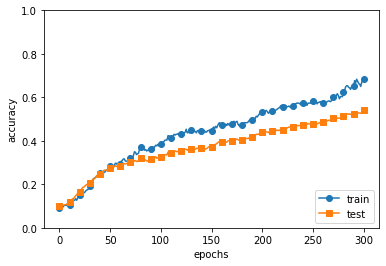

In [18]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# Dropuoutの有無、割り合いの設定 ========================
use_dropout = True  # Dropoutなしのときの場合はFalseに
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()